In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [3]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [4]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [5]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [6]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [7]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [8]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [9]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [10]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, input_shape=(timesteps, features)))
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(1, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [11]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [12]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [13]:
#load modelo forecast close
model_close = tf.keras.models.load_model('modelo_aux_close_9.h5', custom_objects={'rmse': rmse})# Show the model architecture
model_close.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 21,377
Trainable params: 21,377
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito do Open normalizado
    yhat_aux = model_close.predict(inp)  #dá o valor predito do Close normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0],yhat_aux[0][0]]],axis=0)
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}
# record da history de cada modelo
record = {}

In [17]:
n_variate = 2

Epoch 1/10
51/51 [==============================] - 3s 24ms/step - loss: 0.1907 - mae: 0.1882 - rmse: 0.1907 - val_loss: 0.0114 - val_mae: 0.0103 - val_rmse: 0.0116
Epoch 2/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0474 - mae: 0.0431 - rmse: 0.0474 - val_loss: 0.0068 - val_mae: 0.0060 - val_rmse: 0.0069
Epoch 3/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0770 - mae: 0.0738 - rmse: 0.0770 - val_loss: 0.0093 - val_mae: 0.0077 - val_rmse: 0.0091
Epoch 4/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0768 - mae: 0.0737 - rmse: 0.0768 - val_loss: 0.0188 - val_mae: 0.0179 - val_rmse: 0.0185
Epoch 5/10
51/51 [==============================] - 0s 5ms/step - loss: 0.1362 - mae: 0.1340 - rmse: 0.1362 - val_loss: 0.0574 - val_mae: 0.0571 - val_rmse: 0.0576

Epoch 00005: val_loss improved from inf to 0.05738, saving model to my_model_5_0.057.h5
Epoch 6/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0946 - mae: 0.09

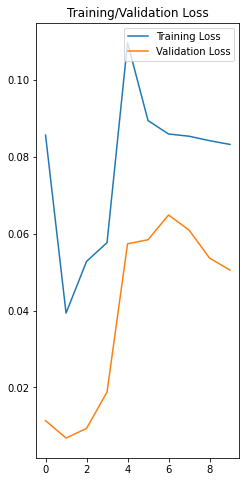

Epoch 1/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0668 - mae: 0.0649 - rmse: 0.0667 - val_loss: 0.0189 - val_mae: 0.0167 - val_rmse: 0.0178
Epoch 2/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0803 - mae: 0.0785 - rmse: 0.0798 - val_loss: 0.0325 - val_mae: 0.0307 - val_rmse: 0.0319
Epoch 3/10
102/102 [==============================] - 0s 5ms/step - loss: 0.0672 - mae: 0.0654 - rmse: 0.0669 - val_loss: 0.0215 - val_mae: 0.0202 - val_rmse: 0.0208
Epoch 4/10
102/102 [==============================] - 0s 5ms/step - loss: 0.0646 - mae: 0.0628 - rmse: 0.0644 - val_loss: 0.0239 - val_mae: 0.0223 - val_rmse: 0.0232
Epoch 5/10
102/102 [==============================] - 0s 5ms/step - loss: 0.0612 - mae: 0.0594 - rmse: 0.0609 - val_loss: 0.0244 - val_mae: 0.0228 - val_rmse: 0.0237

Epoch 00005: val_loss improved from 0.05054 to 0.02440, saving model to my_model_5_0.024.h5
Epoch 6/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0

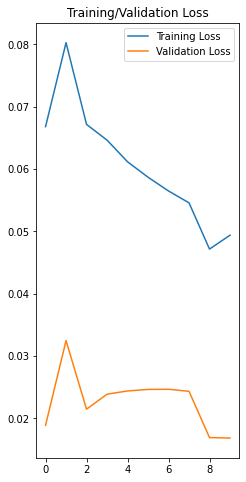

Epoch 1/10
152/152 [==============================] - 2s 5ms/step - loss: 0.0284 - mae: 0.0265 - rmse: 0.0284 - val_loss: 0.0379 - val_mae: 0.0329 - val_rmse: 0.0383
Epoch 2/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0241 - mae: 0.0219 - rmse: 0.0241 - val_loss: 0.0331 - val_mae: 0.0277 - val_rmse: 0.0331
Epoch 3/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0171 - mae: 0.0149 - rmse: 0.0171 - val_loss: 0.0296 - val_mae: 0.0254 - val_rmse: 0.0298
Epoch 4/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0210 - mae: 0.0188 - rmse: 0.0210 - val_loss: 0.0316 - val_mae: 0.0268 - val_rmse: 0.0315
Epoch 5/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0167 - mae: 0.0146 - rmse: 0.0167 - val_loss: 0.0277 - val_mae: 0.0239 - val_rmse: 0.0278

Epoch 00005: val_loss did not improve from 0.01685
Epoch 6/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0201 - mae: 0.0180 - rmse: 0.0201 - val_lo

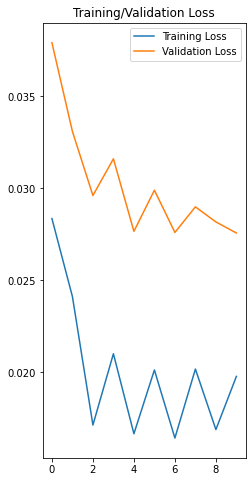

[array([[2493.252]], dtype=float32), array([[2497.4268]], dtype=float32), array([[2500.9468]], dtype=float32), array([[2502.139]], dtype=float32), array([[2504.5066]], dtype=float32), array([[2507.946]], dtype=float32), array([[2511.465]], dtype=float32), array([[2514.958]], dtype=float32), array([[2518.243]], dtype=float32), array([[2521.4277]], dtype=float32), array([[2524.539]], dtype=float32), array([[2527.4465]], dtype=float32), array([[2530.149]], dtype=float32), array([[2532.689]], dtype=float32), array([[2535.0852]], dtype=float32)]
[2493.252, 2497.4268, 2500.9468, 2502.139, 2504.5066, 2507.946, 2511.465, 2514.958, 2518.243, 2521.4277, 2524.539, 2527.4465, 2530.149, 2532.689, 2535.0852]


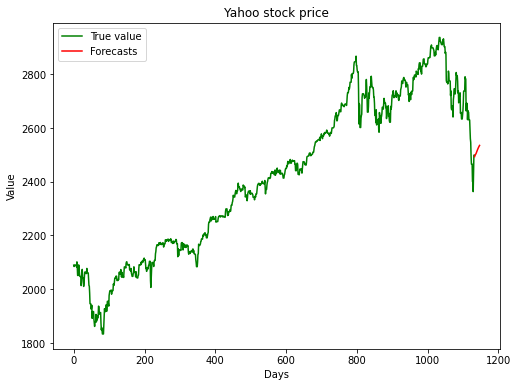

Epoch 1/50
51/51 [==============================] - 2s 15ms/step - loss: 0.2314 - mae: 0.2294 - rmse: 0.2314 - val_loss: 0.0157 - val_mae: 0.0147 - val_rmse: 0.0154
Epoch 2/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0655 - mae: 0.0621 - rmse: 0.0655 - val_loss: 0.0138 - val_mae: 0.0125 - val_rmse: 0.0135
Epoch 3/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0815 - mae: 0.0785 - rmse: 0.0815 - val_loss: 0.0104 - val_mae: 0.0089 - val_rmse: 0.0102
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0899 - mae: 0.0871 - rmse: 0.0899 - val_loss: 0.0167 - val_mae: 0.0157 - val_rmse: 0.0164
Epoch 5/50
51/51 [==============================] - 0s 6ms/step - loss: 0.1480 - mae: 0.1461 - rmse: 0.1480 - val_loss: 0.0572 - val_mae: 0.0569 - val_rmse: 0.0574

Epoch 00005: val_loss improved from inf to 0.05717, saving model to my_model_5_0.057.h5
Epoch 6/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0926 - mae: 0.08

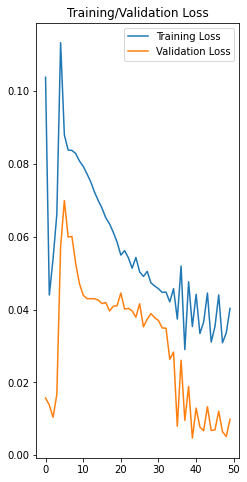

Epoch 1/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0239 - mae: 0.0217 - rmse: 0.0238 - val_loss: 0.0124 - val_mae: 0.0110 - val_rmse: 0.0125
Epoch 2/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0294 - mae: 0.0275 - rmse: 0.0293 - val_loss: 0.0233 - val_mae: 0.0220 - val_rmse: 0.0222
Epoch 3/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0337 - mae: 0.0317 - rmse: 0.0336 - val_loss: 0.0214 - val_mae: 0.0202 - val_rmse: 0.0203
Epoch 4/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0423 - mae: 0.0407 - rmse: 0.0421 - val_loss: 0.0154 - val_mae: 0.0144 - val_rmse: 0.0147
Epoch 5/50
102/102 [==============================] - 0s 5ms/step - loss: 0.0410 - mae: 0.0394 - rmse: 0.0408 - val_loss: 0.0205 - val_mae: 0.0193 - val_rmse: 0.0192

Epoch 00005: val_loss did not improve from 0.00471
Epoch 6/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0281 - mae: 0.0261 - rmse: 0.0280 - val_lo

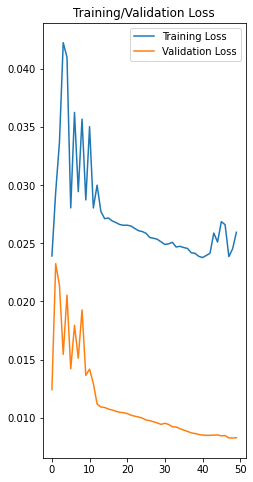

Epoch 1/50
152/152 [==============================] - 2s 5ms/step - loss: 0.0186 - mae: 0.0166 - rmse: 0.0186 - val_loss: 0.0247 - val_mae: 0.0216 - val_rmse: 0.0246
Epoch 2/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0254 - mae: 0.0238 - rmse: 0.0254 - val_loss: 0.0256 - val_mae: 0.0224 - val_rmse: 0.0255
Epoch 3/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0217 - mae: 0.0199 - rmse: 0.0217 - val_loss: 0.0259 - val_mae: 0.0225 - val_rmse: 0.0257
Epoch 4/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0191 - mae: 0.0172 - rmse: 0.0191 - val_loss: 0.0276 - val_mae: 0.0241 - val_rmse: 0.0274
Epoch 5/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0234 - mae: 0.0216 - rmse: 0.0234 - val_loss: 0.0229 - val_mae: 0.0201 - val_rmse: 0.0228

Epoch 00005: val_loss did not improve from 0.00471
Epoch 6/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0167 - mae: 0.0147 - rmse: 0.0167 - val_lo

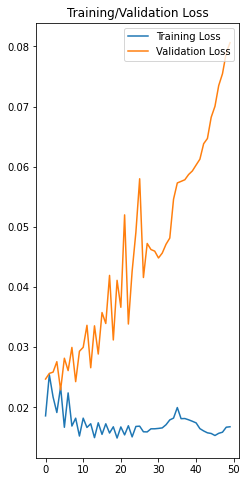

[array([[2503.7053]], dtype=float32), array([[2514.2695]], dtype=float32), array([[2521.7166]], dtype=float32), array([[2526.753]], dtype=float32), array([[2532.6833]], dtype=float32), array([[2539.2258]], dtype=float32), array([[2546.0803]], dtype=float32), array([[2553.4194]], dtype=float32), array([[2560.9355]], dtype=float32), array([[2568.6038]], dtype=float32), array([[2576.3433]], dtype=float32), array([[2583.9524]], dtype=float32), array([[2591.3855]], dtype=float32), array([[2598.63]], dtype=float32), array([[2605.673]], dtype=float32)]
[2503.7053, 2514.2695, 2521.7166, 2526.753, 2532.6833, 2539.2258, 2546.0803, 2553.4194, 2560.9355, 2568.6038, 2576.3433, 2583.9524, 2591.3855, 2598.63, 2605.673]


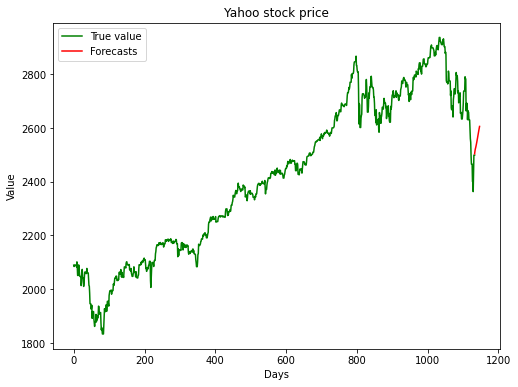

Epoch 1/100
51/51 [==============================] - 2s 16ms/step - loss: 0.1395 - mae: 0.1368 - rmse: 0.1394 - val_loss: 0.0082 - val_mae: 0.0066 - val_rmse: 0.0080
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0525 - mae: 0.0492 - rmse: 0.0525 - val_loss: 0.0075 - val_mae: 0.0059 - val_rmse: 0.0073
Epoch 3/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0472 - mae: 0.0432 - rmse: 0.0472 - val_loss: 0.0060 - val_mae: 0.0052 - val_rmse: 0.0061
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0667 - mae: 0.0636 - rmse: 0.0667 - val_loss: 0.0135 - val_mae: 0.0124 - val_rmse: 0.0133
Epoch 5/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0771 - mae: 0.0745 - rmse: 0.0771 - val_loss: 0.0264 - val_mae: 0.0258 - val_rmse: 0.0262

Epoch 00005: val_loss improved from inf to 0.02641, saving model to my_model_5_0.026.h5
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0906 - mae

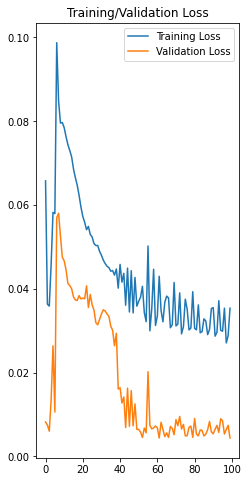

Epoch 1/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0202 - mae: 0.0180 - rmse: 0.0201 - val_loss: 0.0107 - val_mae: 0.0097 - val_rmse: 0.0113
Epoch 2/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0250 - mae: 0.0230 - rmse: 0.0249 - val_loss: 0.0199 - val_mae: 0.0188 - val_rmse: 0.0187
Epoch 3/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0263 - mae: 0.0243 - rmse: 0.0262 - val_loss: 0.0130 - val_mae: 0.0117 - val_rmse: 0.0129
Epoch 4/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0275 - mae: 0.0257 - rmse: 0.0274 - val_loss: 0.0198 - val_mae: 0.0187 - val_rmse: 0.0185
Epoch 5/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0362 - mae: 0.0346 - rmse: 0.0360 - val_loss: 0.0121 - val_mae: 0.0109 - val_rmse: 0.0123

Epoch 00005: val_loss did not improve from 0.00440
Epoch 6/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0250 - mae: 0.0230 - rmse: 0.0249 - 

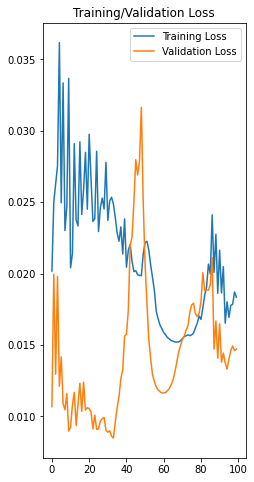

Epoch 1/100
152/152 [==============================] - 2s 5ms/step - loss: 0.0172 - mae: 0.0155 - rmse: 0.0172 - val_loss: 0.0456 - val_mae: 0.0414 - val_rmse: 0.0454
Epoch 2/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0175 - mae: 0.0158 - rmse: 0.0175 - val_loss: 0.0356 - val_mae: 0.0311 - val_rmse: 0.0356
Epoch 3/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0190 - mae: 0.0173 - rmse: 0.0190 - val_loss: 0.0451 - val_mae: 0.0415 - val_rmse: 0.0448
Epoch 4/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0227 - mae: 0.0210 - rmse: 0.0227 - val_loss: 0.0506 - val_mae: 0.0470 - val_rmse: 0.0502
Epoch 5/100
152/152 [==============================] - 1s 4ms/step - loss: 0.0184 - mae: 0.0166 - rmse: 0.0184 - val_loss: 0.0600 - val_mae: 0.0560 - val_rmse: 0.0595

Epoch 00005: val_loss did not improve from 0.00440
Epoch 6/100
152/152 [==============================] - 1s 4ms/step - loss: 0.0163 - mae: 0.0144 - rmse: 0.0163 - 

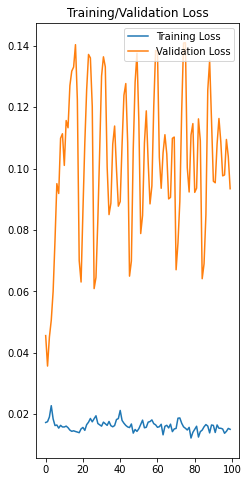

[array([[2480.1746]], dtype=float32), array([[2479.9226]], dtype=float32), array([[2483.98]], dtype=float32), array([[2485.332]], dtype=float32), array([[2487.808]], dtype=float32), array([[2490.2917]], dtype=float32), array([[2492.3005]], dtype=float32), array([[2494.0603]], dtype=float32), array([[2495.441]], dtype=float32), array([[2496.875]], dtype=float32), array([[2498.4387]], dtype=float32), array([[2499.9668]], dtype=float32), array([[2501.4397]], dtype=float32), array([[2502.871]], dtype=float32), array([[2504.2695]], dtype=float32)]
[2480.1746, 2479.9226, 2483.98, 2485.332, 2487.808, 2490.2917, 2492.3005, 2494.0603, 2495.441, 2496.875, 2498.4387, 2499.9668, 2501.4397, 2502.871, 2504.2695]


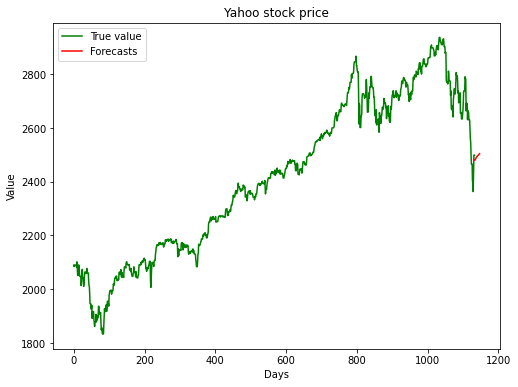

Epoch 1/60
51/51 [==============================] - 3s 17ms/step - loss: 0.1943 - mae: 0.1920 - rmse: 0.1942 - val_loss: 0.0072 - val_mae: 0.0065 - val_rmse: 0.0073
Epoch 2/60
51/51 [==============================] - 0s 8ms/step - loss: 0.0485 - mae: 0.0447 - rmse: 0.0485 - val_loss: 0.0159 - val_mae: 0.0149 - val_rmse: 0.0156
Epoch 3/60
51/51 [==============================] - 0s 7ms/step - loss: 0.0617 - mae: 0.0578 - rmse: 0.0617 - val_loss: 0.0170 - val_mae: 0.0160 - val_rmse: 0.0167
Epoch 4/60
51/51 [==============================] - 0s 7ms/step - loss: 0.0906 - mae: 0.0876 - rmse: 0.0906 - val_loss: 0.0107 - val_mae: 0.0091 - val_rmse: 0.0104
Epoch 5/60
51/51 [==============================] - 0s 7ms/step - loss: 0.1359 - mae: 0.1335 - rmse: 0.1359 - val_loss: 0.0273 - val_mae: 0.0267 - val_rmse: 0.0275

Epoch 00005: val_loss improved from inf to 0.02729, saving model to my_model_5_0.027.h5
Epoch 6/60
51/51 [==============================] - 0s 7ms/step - loss: 0.1176 - mae: 0.11

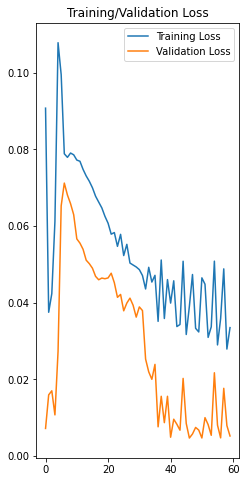

Epoch 1/60
102/102 [==============================] - 1s 7ms/step - loss: 0.0340 - mae: 0.0323 - rmse: 0.0338 - val_loss: 0.0118 - val_mae: 0.0104 - val_rmse: 0.0120
Epoch 2/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0251 - mae: 0.0232 - rmse: 0.0250 - val_loss: 0.0200 - val_mae: 0.0188 - val_rmse: 0.0189
Epoch 3/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0379 - mae: 0.0362 - rmse: 0.0377 - val_loss: 0.0136 - val_mae: 0.0126 - val_rmse: 0.0132
Epoch 4/60
102/102 [==============================] - 1s 7ms/step - loss: 0.0376 - mae: 0.0360 - rmse: 0.0373 - val_loss: 0.0161 - val_mae: 0.0147 - val_rmse: 0.0154
Epoch 5/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0310 - mae: 0.0292 - rmse: 0.0308 - val_loss: 0.0143 - val_mae: 0.0133 - val_rmse: 0.0137

Epoch 00005: val_loss did not improve from 0.00519
Epoch 6/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0396 - mae: 0.0381 - rmse: 0.0394 - val_lo

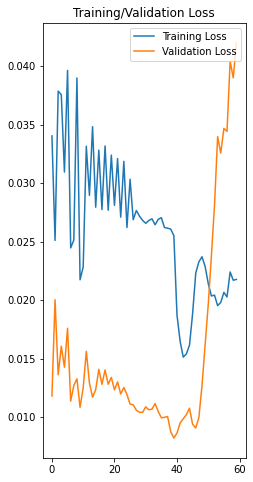

Epoch 1/60
152/152 [==============================] - 1s 7ms/step - loss: 0.0211 - mae: 0.0193 - rmse: 0.0211 - val_loss: 0.0586 - val_mae: 0.0535 - val_rmse: 0.0584
Epoch 2/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0258 - mae: 0.0240 - rmse: 0.0258 - val_loss: 0.0372 - val_mae: 0.0310 - val_rmse: 0.0373
Epoch 3/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0285 - mae: 0.0268 - rmse: 0.0285 - val_loss: 0.0350 - val_mae: 0.0297 - val_rmse: 0.0350
Epoch 4/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0266 - mae: 0.0250 - rmse: 0.0266 - val_loss: 0.0395 - val_mae: 0.0346 - val_rmse: 0.0393
Epoch 5/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0251 - mae: 0.0235 - rmse: 0.0251 - val_loss: 0.0489 - val_mae: 0.0452 - val_rmse: 0.0486

Epoch 00005: val_loss did not improve from 0.00519
Epoch 6/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0181 - mae: 0.0162 - rmse: 0.0181 - val_lo

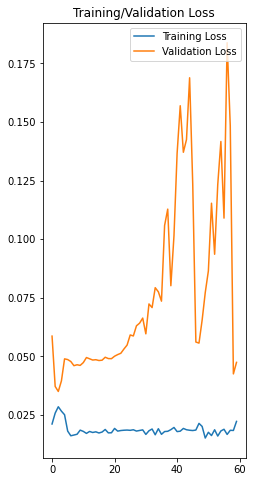

[array([[2498.729]], dtype=float32), array([[2507.8257]], dtype=float32), array([[2514.6665]], dtype=float32), array([[2520.4045]], dtype=float32), array([[2523.9658]], dtype=float32), array([[2528.8577]], dtype=float32), array([[2534.4465]], dtype=float32), array([[2539.8801]], dtype=float32), array([[2545.42]], dtype=float32), array([[2550.842]], dtype=float32), array([[2556.1848]], dtype=float32), array([[2561.415]], dtype=float32), array([[2566.5054]], dtype=float32), array([[2571.333]], dtype=float32), array([[2575.9048]], dtype=float32)]
[2498.729, 2507.8257, 2514.6665, 2520.4045, 2523.9658, 2528.8577, 2534.4465, 2539.8801, 2545.42, 2550.842, 2556.1848, 2561.415, 2566.5054, 2571.333, 2575.9048]


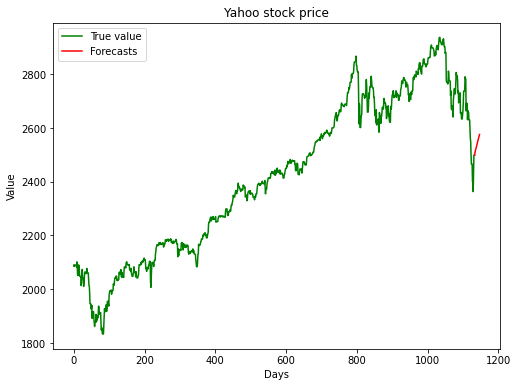

Epoch 1/90
51/51 [==============================] - 3s 16ms/step - loss: 0.1420 - mae: 0.1388 - rmse: 0.1420 - val_loss: 0.0083 - val_mae: 0.0066 - val_rmse: 0.0081
Epoch 2/90
51/51 [==============================] - 0s 6ms/step - loss: 0.0460 - mae: 0.0423 - rmse: 0.0460 - val_loss: 0.0089 - val_mae: 0.0072 - val_rmse: 0.0086
Epoch 3/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0454 - mae: 0.0421 - rmse: 0.0454 - val_loss: 0.0088 - val_mae: 0.0071 - val_rmse: 0.0085
Epoch 4/90
51/51 [==============================] - 0s 6ms/step - loss: 0.0486 - mae: 0.0448 - rmse: 0.0485 - val_loss: 0.0165 - val_mae: 0.0155 - val_rmse: 0.0162
Epoch 5/90
51/51 [==============================] - 0s 6ms/step - loss: 0.0627 - mae: 0.0589 - rmse: 0.0627 - val_loss: 0.0113 - val_mae: 0.0097 - val_rmse: 0.0110

Epoch 00005: val_loss improved from inf to 0.01130, saving model to my_model_5_0.011.h5
Epoch 6/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0970 - mae: 0.09

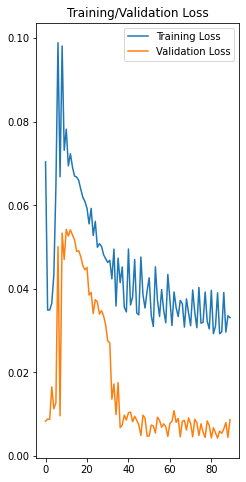

Epoch 1/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0238 - mae: 0.0217 - rmse: 0.0236 - val_loss: 0.0129 - val_mae: 0.0116 - val_rmse: 0.0128
Epoch 2/90
102/102 [==============================] - 1s 6ms/step - loss: 0.0282 - mae: 0.0264 - rmse: 0.0281 - val_loss: 0.0207 - val_mae: 0.0196 - val_rmse: 0.0195
Epoch 3/90
102/102 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.0259 - rmse: 0.0275 - val_loss: 0.0111 - val_mae: 0.0099 - val_rmse: 0.0114
Epoch 4/90
102/102 [==============================] - 1s 6ms/step - loss: 0.0266 - mae: 0.0247 - rmse: 0.0264 - val_loss: 0.0184 - val_mae: 0.0172 - val_rmse: 0.0172
Epoch 5/90
102/102 [==============================] - 1s 6ms/step - loss: 0.0344 - mae: 0.0327 - rmse: 0.0342 - val_loss: 0.0111 - val_mae: 0.0101 - val_rmse: 0.0112

Epoch 00005: val_loss did not improve from 0.00468
Epoch 6/90
102/102 [==============================] - 1s 6ms/step - loss: 0.0349 - mae: 0.0332 - rmse: 0.0346 - val_lo

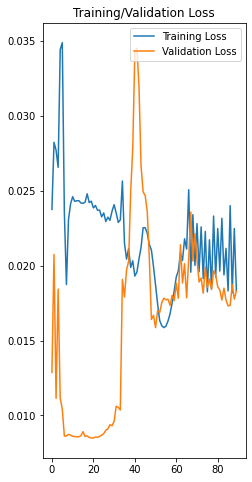

Epoch 1/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0226 - mae: 0.0208 - rmse: 0.0226 - val_loss: 0.0732 - val_mae: 0.0682 - val_rmse: 0.0727
Epoch 2/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0185 - mae: 0.0165 - rmse: 0.0185 - val_loss: 0.0702 - val_mae: 0.0659 - val_rmse: 0.0698
Epoch 3/90
152/152 [==============================] - 1s 7ms/step - loss: 0.0224 - mae: 0.0205 - rmse: 0.0223 - val_loss: 0.0412 - val_mae: 0.0367 - val_rmse: 0.0410
Epoch 4/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0211 - mae: 0.0193 - rmse: 0.0211 - val_loss: 0.0434 - val_mae: 0.0396 - val_rmse: 0.0432
Epoch 5/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0185 - mae: 0.0165 - rmse: 0.0185 - val_loss: 0.0440 - val_mae: 0.0405 - val_rmse: 0.0437

Epoch 00005: val_loss did not improve from 0.00468
Epoch 6/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0176 - mae: 0.0158 - rmse: 0.0176 - val_lo

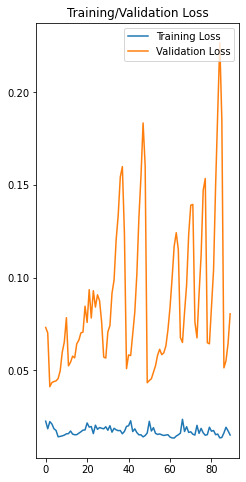

[array([[2495.9214]], dtype=float32), array([[2503.2185]], dtype=float32), array([[2510.383]], dtype=float32), array([[2517.0347]], dtype=float32), array([[2521.0864]], dtype=float32), array([[2526.098]], dtype=float32), array([[2531.7744]], dtype=float32), array([[2537.4001]], dtype=float32), array([[2543.209]], dtype=float32), array([[2548.9355]], dtype=float32), array([[2554.6191]], dtype=float32), array([[2560.2654]], dtype=float32), array([[2565.8708]], dtype=float32), array([[2571.3022]], dtype=float32), array([[2576.5388]], dtype=float32)]
[2495.9214, 2503.2185, 2510.383, 2517.0347, 2521.0864, 2526.098, 2531.7744, 2537.4001, 2543.209, 2548.9355, 2554.6191, 2560.2654, 2565.8708, 2571.3022, 2576.5388]


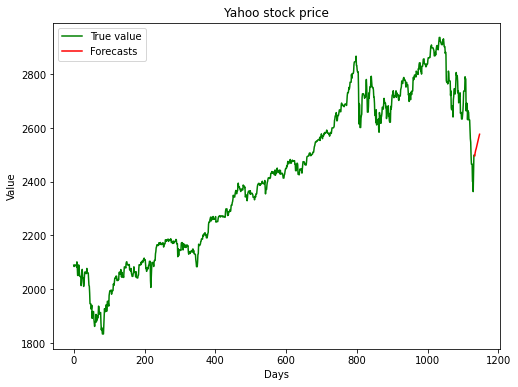

Epoch 1/120
51/51 [==============================] - 3s 16ms/step - loss: 0.1265 - mae: 0.1237 - rmse: 0.1265 - val_loss: 0.0075 - val_mae: 0.0060 - val_rmse: 0.0073
Epoch 2/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0471 - mae: 0.0430 - rmse: 0.0471 - val_loss: 0.0068 - val_mae: 0.0054 - val_rmse: 0.0067
Epoch 3/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0445 - mae: 0.0411 - rmse: 0.0445 - val_loss: 0.0066 - val_mae: 0.0052 - val_rmse: 0.0065
Epoch 4/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0467 - mae: 0.0429 - rmse: 0.0467 - val_loss: 0.0124 - val_mae: 0.0112 - val_rmse: 0.0122
Epoch 5/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0555 - mae: 0.0519 - rmse: 0.0555 - val_loss: 0.0156 - val_mae: 0.0146 - val_rmse: 0.0153

Epoch 00005: val_loss improved from inf to 0.01560, saving model to my_model_5_0.016.h5
Epoch 6/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0822 - mae

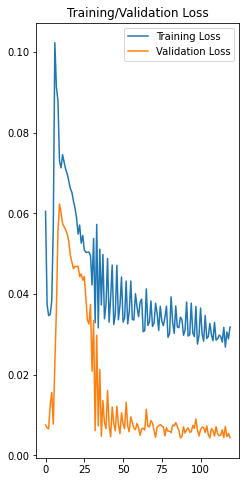

Epoch 1/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.0184 - rmse: 0.0205 - val_loss: 0.0086 - val_mae: 0.0074 - val_rmse: 0.0096
Epoch 2/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0228 - mae: 0.0207 - rmse: 0.0227 - val_loss: 0.0085 - val_mae: 0.0073 - val_rmse: 0.0094
Epoch 3/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0238 - mae: 0.0218 - rmse: 0.0236 - val_loss: 0.0085 - val_mae: 0.0072 - val_rmse: 0.0094
Epoch 4/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0235 - mae: 0.0214 - rmse: 0.0233 - val_loss: 0.0084 - val_mae: 0.0071 - val_rmse: 0.0094
Epoch 5/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0235 - mae: 0.0214 - rmse: 0.0233 - val_loss: 0.0084 - val_mae: 0.0070 - val_rmse: 0.0095

Epoch 00005: val_loss did not improve from 0.00440
Epoch 6/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0228 - mae: 0.0208 - rmse: 0.0227 - 

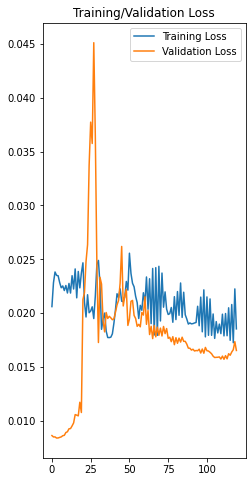

Epoch 1/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0210 - mae: 0.0192 - rmse: 0.0210 - val_loss: 0.0942 - val_mae: 0.0897 - val_rmse: 0.0935
Epoch 2/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0190 - mae: 0.0172 - rmse: 0.0190 - val_loss: 0.0839 - val_mae: 0.0793 - val_rmse: 0.0833
Epoch 3/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0156 - mae: 0.0136 - rmse: 0.0156 - val_loss: 0.1035 - val_mae: 0.0974 - val_rmse: 0.1029
Epoch 4/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0166 - mae: 0.0146 - rmse: 0.0166 - val_loss: 0.1048 - val_mae: 0.0992 - val_rmse: 0.1041
Epoch 5/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0197 - mae: 0.0177 - rmse: 0.0197 - val_loss: 0.0912 - val_mae: 0.0865 - val_rmse: 0.0906

Epoch 00005: val_loss did not improve from 0.00440
Epoch 6/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0190 - mae: 0.0171 - rmse: 0.0190 - 

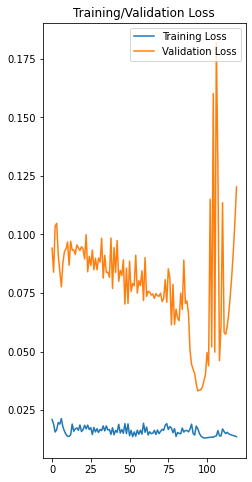

[array([[2497.0195]], dtype=float32), array([[2504.5269]], dtype=float32), array([[2511.537]], dtype=float32), array([[2517.5635]], dtype=float32), array([[2521.5386]], dtype=float32), array([[2526.7468]], dtype=float32), array([[2532.7275]], dtype=float32), array([[2538.9163]], dtype=float32), array([[2545.2288]], dtype=float32), array([[2551.498]], dtype=float32), array([[2557.7898]], dtype=float32), array([[2564.056]], dtype=float32), array([[2570.2842]], dtype=float32), array([[2576.3616]], dtype=float32), array([[2582.2852]], dtype=float32)]
[2497.0195, 2504.5269, 2511.537, 2517.5635, 2521.5386, 2526.7468, 2532.7275, 2538.9163, 2545.2288, 2551.498, 2557.7898, 2564.056, 2570.2842, 2576.3616, 2582.2852]


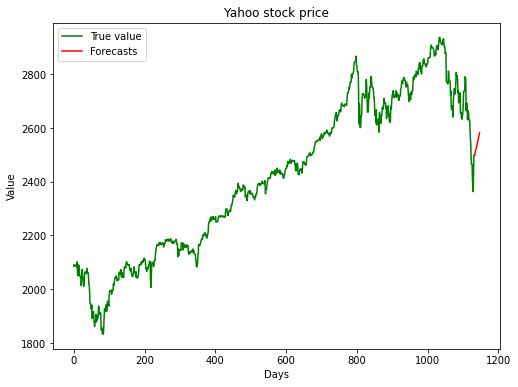

Epoch 1/50
32/32 [==============================] - 3s 25ms/step - loss: 0.2520 - mae: 0.2495 - rmse: 0.2520 - val_loss: 0.0592 - val_mae: 0.0587 - val_rmse: 0.0589
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0634 - mae: 0.0593 - rmse: 0.0634 - val_loss: 0.0282 - val_mae: 0.0271 - val_rmse: 0.0280
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0660 - mae: 0.0613 - rmse: 0.0660 - val_loss: 0.0272 - val_mae: 0.0262 - val_rmse: 0.0271
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0627 - mae: 0.0581 - rmse: 0.0626 - val_loss: 0.0245 - val_mae: 0.0234 - val_rmse: 0.0244
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0634 - mae: 0.0590 - rmse: 0.0634 - val_loss: 0.0194 - val_mae: 0.0182 - val_rmse: 0.0194

Epoch 00005: val_loss improved from inf to 0.01941, saving model to my_model_5_0.019.h5
Epoch 6/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0642 - mae: 0.

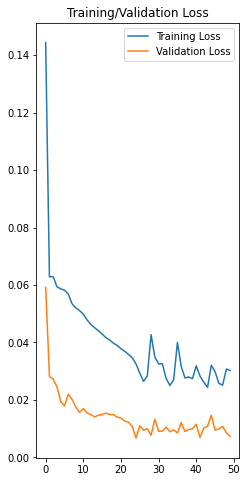

Epoch 1/50
64/64 [==============================] - 1s 16ms/step - loss: 0.0192 - mae: 0.0164 - rmse: 0.0190 - val_loss: 0.0112 - val_mae: 0.0091 - val_rmse: 0.0112
Epoch 2/50
64/64 [==============================] - 0s 8ms/step - loss: 0.0259 - mae: 0.0233 - rmse: 0.0257 - val_loss: 0.0206 - val_mae: 0.0191 - val_rmse: 0.0206
Epoch 3/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0251 - mae: 0.0225 - rmse: 0.0249 - val_loss: 0.0157 - val_mae: 0.0138 - val_rmse: 0.0157
Epoch 4/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0318 - mae: 0.0298 - rmse: 0.0315 - val_loss: 0.0135 - val_mae: 0.0116 - val_rmse: 0.0135
Epoch 5/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0269 - mae: 0.0242 - rmse: 0.0267 - val_loss: 0.0206 - val_mae: 0.0191 - val_rmse: 0.0206

Epoch 00005: val_loss did not improve from 0.00673
Epoch 6/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0264 - mae: 0.0239 - rmse: 0.0262 - val_loss: 0.0177 

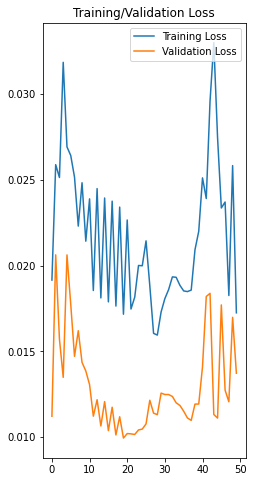

Epoch 1/50
95/95 [==============================] - 1s 9ms/step - loss: 0.0192 - mae: 0.0170 - rmse: 0.0192 - val_loss: 0.0310 - val_mae: 0.0258 - val_rmse: 0.0318
Epoch 2/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0159 - mae: 0.0135 - rmse: 0.0159 - val_loss: 0.0300 - val_mae: 0.0250 - val_rmse: 0.0306
Epoch 3/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0193 - mae: 0.0170 - rmse: 0.0193 - val_loss: 0.0306 - val_mae: 0.0255 - val_rmse: 0.0313
Epoch 4/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0152 - mae: 0.0130 - rmse: 0.0152 - val_loss: 0.0284 - val_mae: 0.0241 - val_rmse: 0.0289
Epoch 5/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0156 - mae: 0.0132 - rmse: 0.0156 - val_loss: 0.0284 - val_mae: 0.0237 - val_rmse: 0.0289

Epoch 00005: val_loss did not improve from 0.00673
Epoch 6/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0189 - mae: 0.0167 - rmse: 0.0189 - val_loss: 0.0288 -

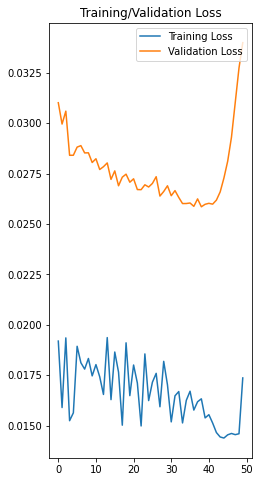

[array([[2501.555]], dtype=float32), array([[2506.4358]], dtype=float32), array([[2505.6748]], dtype=float32), array([[2506.118]], dtype=float32), array([[2509.2493]], dtype=float32), array([[2514.6924]], dtype=float32), array([[2523.303]], dtype=float32), array([[2532.0564]], dtype=float32), array([[2538.832]], dtype=float32), array([[2544.446]], dtype=float32), array([[2549.4307]], dtype=float32), array([[2554.0034]], dtype=float32), array([[2558.5693]], dtype=float32), array([[2563.4075]], dtype=float32), array([[2568.553]], dtype=float32)]
[2501.555, 2506.4358, 2505.6748, 2506.118, 2509.2493, 2514.6924, 2523.303, 2532.0564, 2538.832, 2544.446, 2549.4307, 2554.0034, 2558.5693, 2563.4075, 2568.553]


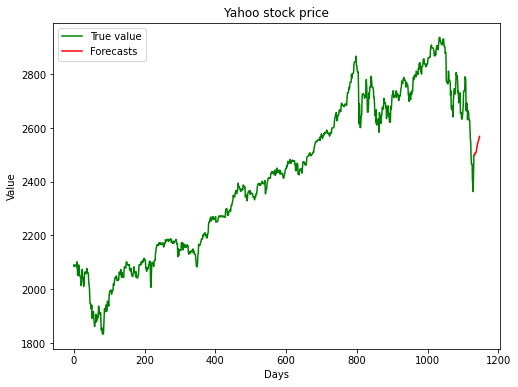

Epoch 1/90
32/32 [==============================] - 3s 25ms/step - loss: 0.1926 - mae: 0.1899 - rmse: 0.1926 - val_loss: 0.0192 - val_mae: 0.0179 - val_rmse: 0.0199
Epoch 2/90
32/32 [==============================] - 0s 9ms/step - loss: 0.1203 - mae: 0.1170 - rmse: 0.1203 - val_loss: 0.0109 - val_mae: 0.0095 - val_rmse: 0.0112
Epoch 3/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0785 - mae: 0.0742 - rmse: 0.0785 - val_loss: 0.0204 - val_mae: 0.0191 - val_rmse: 0.0203
Epoch 4/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0632 - mae: 0.0587 - rmse: 0.0632 - val_loss: 0.0264 - val_mae: 0.0254 - val_rmse: 0.0262
Epoch 5/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0579 - mae: 0.0536 - rmse: 0.0579 - val_loss: 0.0283 - val_mae: 0.0274 - val_rmse: 0.0282

Epoch 00005: val_loss improved from inf to 0.02833, saving model to my_model_5_0.028.h5
Epoch 6/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0577 - mae: 

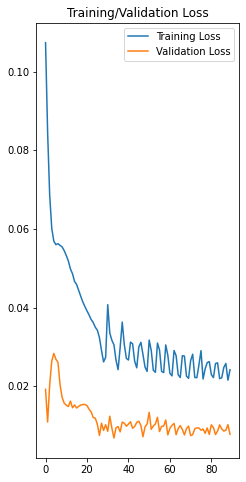

Epoch 1/90
64/64 [==============================] - 1s 17ms/step - loss: 0.0175 - mae: 0.0149 - rmse: 0.0173 - val_loss: 0.0100 - val_mae: 0.0081 - val_rmse: 0.0100
Epoch 2/90
64/64 [==============================] - 1s 9ms/step - loss: 0.0243 - mae: 0.0219 - rmse: 0.0241 - val_loss: 0.0101 - val_mae: 0.0082 - val_rmse: 0.0101
Epoch 3/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0153 - mae: 0.0128 - rmse: 0.0152 - val_loss: 0.0148 - val_mae: 0.0118 - val_rmse: 0.0148
Epoch 4/90
64/64 [==============================] - 1s 9ms/step - loss: 0.0158 - mae: 0.0135 - rmse: 0.0158 - val_loss: 0.0114 - val_mae: 0.0094 - val_rmse: 0.0114
Epoch 5/90
64/64 [==============================] - 1s 9ms/step - loss: 0.0165 - mae: 0.0143 - rmse: 0.0166 - val_loss: 0.0126 - val_mae: 0.0107 - val_rmse: 0.0126

Epoch 00005: val_loss did not improve from 0.00761
Epoch 6/90
64/64 [==============================] - 1s 9ms/step - loss: 0.0177 - mae: 0.0153 - rmse: 0.0177 - val_loss: 0.0124 

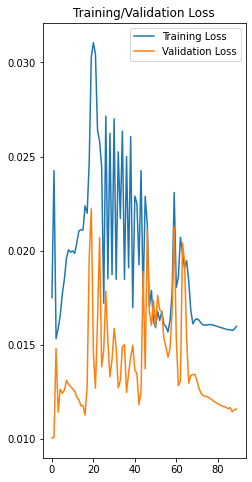

Epoch 1/90
95/95 [==============================] - 1s 9ms/step - loss: 0.0142 - mae: 0.0119 - rmse: 0.0142 - val_loss: 0.0294 - val_mae: 0.0249 - val_rmse: 0.0303
Epoch 2/90
95/95 [==============================] - 1s 9ms/step - loss: 0.0135 - mae: 0.0112 - rmse: 0.0135 - val_loss: 0.0275 - val_mae: 0.0237 - val_rmse: 0.0284
Epoch 3/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0180 - mae: 0.0159 - rmse: 0.0180 - val_loss: 0.0261 - val_mae: 0.0221 - val_rmse: 0.0271
Epoch 4/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0188 - mae: 0.0168 - rmse: 0.0187 - val_loss: 0.0297 - val_mae: 0.0242 - val_rmse: 0.0303
Epoch 5/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0232 - mae: 0.0211 - rmse: 0.0232 - val_loss: 0.0266 - val_mae: 0.0222 - val_rmse: 0.0279

Epoch 00005: val_loss did not improve from 0.00761
Epoch 6/90
95/95 [==============================] - 1s 9ms/step - loss: 0.0133 - mae: 0.0111 - rmse: 0.0133 - val_loss: 0.0306 -

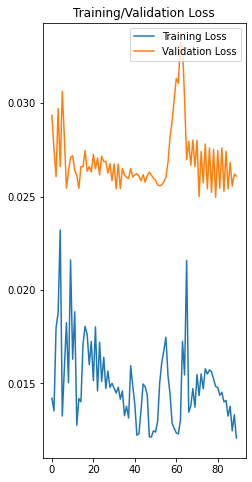

[array([[2489.642]], dtype=float32), array([[2493.144]], dtype=float32), array([[2497.2568]], dtype=float32), array([[2502.4639]], dtype=float32), array([[2507.716]], dtype=float32), array([[2512.0466]], dtype=float32), array([[2515.3633]], dtype=float32), array([[2519.5813]], dtype=float32), array([[2524.2153]], dtype=float32), array([[2528.838]], dtype=float32), array([[2533.4358]], dtype=float32), array([[2537.7795]], dtype=float32), array([[2542.0034]], dtype=float32), array([[2546.103]], dtype=float32), array([[2550.0793]], dtype=float32)]
[2489.642, 2493.144, 2497.2568, 2502.4639, 2507.716, 2512.0466, 2515.3633, 2519.5813, 2524.2153, 2528.838, 2533.4358, 2537.7795, 2542.0034, 2546.103, 2550.0793]


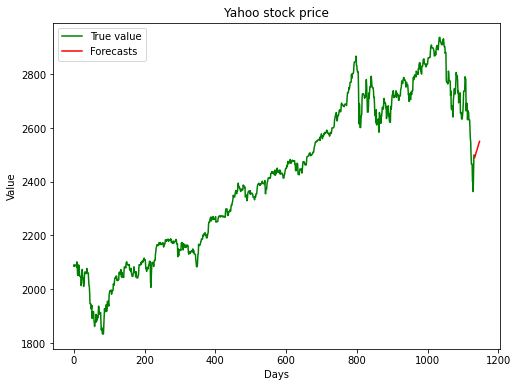

Epoch 1/120
32/32 [==============================] - 3s 26ms/step - loss: 0.2907 - mae: 0.2885 - rmse: 0.2906 - val_loss: 0.0657 - val_mae: 0.0653 - val_rmse: 0.0654
Epoch 2/120
32/32 [==============================] - 0s 10ms/step - loss: 0.0658 - mae: 0.0613 - rmse: 0.0658 - val_loss: 0.0399 - val_mae: 0.0391 - val_rmse: 0.0396
Epoch 3/120
32/32 [==============================] - 0s 10ms/step - loss: 0.0706 - mae: 0.0662 - rmse: 0.0706 - val_loss: 0.0361 - val_mae: 0.0354 - val_rmse: 0.0359
Epoch 4/120
32/32 [==============================] - 0s 10ms/step - loss: 0.0732 - mae: 0.0686 - rmse: 0.0732 - val_loss: 0.0261 - val_mae: 0.0250 - val_rmse: 0.0259
Epoch 5/120
32/32 [==============================] - 0s 11ms/step - loss: 0.0774 - mae: 0.0730 - rmse: 0.0774 - val_loss: 0.0185 - val_mae: 0.0173 - val_rmse: 0.0185

Epoch 00005: val_loss improved from inf to 0.01852, saving model to my_model_5_0.019.h5
Epoch 6/120
32/32 [==============================] - 0s 10ms/step - loss: 0.0794 

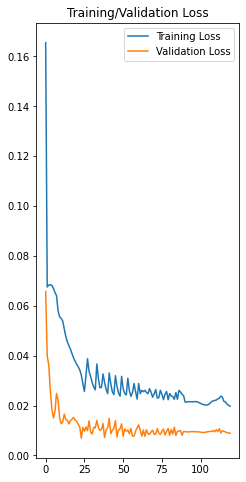

Epoch 1/120
64/64 [==============================] - 1s 16ms/step - loss: 0.0150 - mae: 0.0127 - rmse: 0.0148 - val_loss: 0.0120 - val_mae: 0.0093 - val_rmse: 0.0120
Epoch 2/120
64/64 [==============================] - 1s 8ms/step - loss: 0.0148 - mae: 0.0124 - rmse: 0.0146 - val_loss: 0.0105 - val_mae: 0.0079 - val_rmse: 0.0105
Epoch 3/120
64/64 [==============================] - 1s 9ms/step - loss: 0.0207 - mae: 0.0184 - rmse: 0.0206 - val_loss: 0.0183 - val_mae: 0.0168 - val_rmse: 0.0183
Epoch 4/120
64/64 [==============================] - 1s 9ms/step - loss: 0.0208 - mae: 0.0185 - rmse: 0.0206 - val_loss: 0.0100 - val_mae: 0.0086 - val_rmse: 0.0100
Epoch 5/120
64/64 [==============================] - 1s 10ms/step - loss: 0.0266 - mae: 0.0245 - rmse: 0.0264 - val_loss: 0.0095 - val_mae: 0.0080 - val_rmse: 0.0095

Epoch 00005: val_loss did not improve from 0.00766
Epoch 6/120
64/64 [==============================] - 1s 9ms/step - loss: 0.0190 - mae: 0.0165 - rmse: 0.0188 - val_loss: 

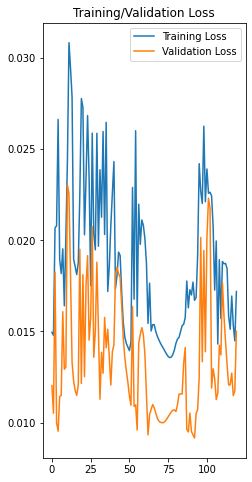

Epoch 1/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0157 - mae: 0.0136 - rmse: 0.0157 - val_loss: 0.0305 - val_mae: 0.0250 - val_rmse: 0.0310
Epoch 2/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0139 - mae: 0.0115 - rmse: 0.0139 - val_loss: 0.0270 - val_mae: 0.0224 - val_rmse: 0.0277
Epoch 3/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0136 - mae: 0.0113 - rmse: 0.0136 - val_loss: 0.0284 - val_mae: 0.0236 - val_rmse: 0.0289
Epoch 4/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0186 - mae: 0.0162 - rmse: 0.0185 - val_loss: 0.0328 - val_mae: 0.0284 - val_rmse: 0.0333
Epoch 5/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0161 - mae: 0.0140 - rmse: 0.0161 - val_loss: 0.0309 - val_mae: 0.0264 - val_rmse: 0.0312

Epoch 00005: val_loss did not improve from 0.00766
Epoch 6/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0222 - mae: 0.0199 - rmse: 0.0222 - val_loss: 0.

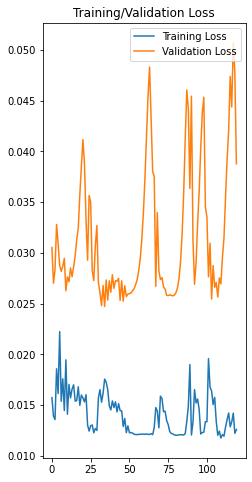

[array([[2486.0498]], dtype=float32), array([[2487.8333]], dtype=float32), array([[2490.1604]], dtype=float32), array([[2493.7058]], dtype=float32), array([[2498.467]], dtype=float32), array([[2503.0532]], dtype=float32), array([[2506.7224]], dtype=float32), array([[2510.6099]], dtype=float32), array([[2514.2058]], dtype=float32), array([[2517.5837]], dtype=float32), array([[2520.959]], dtype=float32), array([[2524.208]], dtype=float32), array([[2527.469]], dtype=float32), array([[2530.6892]], dtype=float32), array([[2533.8525]], dtype=float32)]
[2486.0498, 2487.8333, 2490.1604, 2493.7058, 2498.467, 2503.0532, 2506.7224, 2510.6099, 2514.2058, 2517.5837, 2520.959, 2524.208, 2527.469, 2530.6892, 2533.8525]


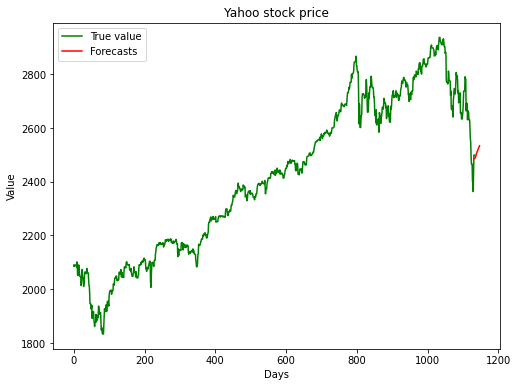

In [18]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [19]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [20]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.0526814720282952, 0.05054999906569719, 0.052560530975461005, 0.030762190821891033, 0.02859211782924831, 0.030548307439312344] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.03355905686194698, 0.03150237758954366, 0.03350500844419003, 0.029168436856319507, 0.027344381416526935, 0.029175630298753582] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.02715018422963718, 0.025118215028196573, 0.027109204623848197, 0.04484934286835293, 0.042130609505499406, 0.04514587750658392] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.03285674249442915, 0.030805038376193906, 0.03275715087333487, 0.040019940002821386, 0.03777581071222408, 0.04015309381453941] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.028030243198628776, 0.025928109280627082, 0.027960013870701742, 0.04059310413862544, 0.0381

In [21]:
print(final_dict)

{1: [0.0526814720282952, 0.05054999906569719, 0.052560530975461005, 0.030762190821891033, 0.02859211782924831, 0.030548307439312344], 2: [0.03355905686194698, 0.03150237758954366, 0.03350500844419003, 0.029168436856319507, 0.027344381416526935, 0.029175630298753582], 3: [0.02715018422963718, 0.025118215028196573, 0.027109204623848197, 0.04484934286835293, 0.042130609505499406, 0.04514587750658392], 4: [0.03285674249442915, 0.030805038376193906, 0.03275715087333487, 0.040019940002821386, 0.03777581071222408, 0.04015309381453941], 5: [0.028030243198628776, 0.025928109280627082, 0.027960013870701742, 0.04059310413862544, 0.03815161946350364, 0.04110025126590497], 6: [0.026068114359966584, 0.023969801805085608, 0.026023026809303296, 0.03765409339167592, 0.035221425020912044, 0.038181137494070254], 7: [0.026247771258155504, 0.023457468698422117, 0.02614988487834732, 0.018238140031074487, 0.01574130751503011, 0.018584445261706908], 8: [0.022805117377666412, 0.020147671578107058, 0.0227315553

In [22]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.052681,0.050550,0.052561,0.030762,0.028592,0.030548
2,0.033559,0.031502,0.033505,0.029168,0.027344,0.029176
3,0.027150,0.025118,0.027109,0.044849,0.042131,0.045146
4,0.032857,0.030805,0.032757,0.040020,0.037776,0.040153
5,0.028030,0.025928,0.027960,0.040593,0.038152,0.041100
6,0.026068,0.023970,0.026023,0.037654,0.035221,0.038181
7,0.026248,0.023457,0.026150,0.018238,0.015741,0.018584
8,0.022805,0.020148,0.022732,0.017523,0.014987,0.018062
9,0.021420,0.018757,0.021340,0.018897,0.016428,0.019504


In [23]:
final_df.to_csv(r"resultados.csv",index=True)